<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/sherifmost/DeepLearning/blob/master/Labs/lab3/Lab3.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# Lab3: Convolutional Neural Network Use Cases

![Simple CNN](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab3/Cover.png?raw=1)

## 3.1 Problem Statement

In this lab you will build several CNN models that check if a person is happy or not. You will use custom made CNN, and CNN use cases either pretrained or not, also you will apply layers freezing on pretrained CNNs and study all those modifications effect on the accuracy.

**IMPORTANT NOTE:** You have to change runtime type on Google Colab to GPU since this lab requires much computation resources and it will run very slowly on CPU (Default runtime type)

Click on "Runtime" => "Change runtime type" => make sure that GPU is selected in the "Hardware accelerator"

## 3.2 Problem Details

### 3.2.1 Packages & Utility Methods

In [5]:
import tensorflow as tf
import numpy as np
# Use this library for resizing the images
import cv2
# import legacy SGD
from keras.optimizers import SGD
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras import applications
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')

from IPython.display import SVG
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pydot
import h5py
import random
import requests

%matplotlib inline

In [6]:
# %pip install pydot

In [7]:
def download_file(file_url):
    file_r = requests.get(file_url, allow_redirects=True)
    open(file_url.rsplit('/', 1)[1], 'wb').write(file_r.content)

### 3.2.2 Dataset Loading

#### Define method to download & load dataset

In [8]:
def load_dataset():
    download_file("https://raw.githubusercontent.com/KhaledElTahan/DeepLearning/master/Labs/lab3/lab3_train.h5")
    download_file("https://raw.githubusercontent.com/KhaledElTahan/DeepLearning/master/Labs/lab3/lab3_test.h5")

    path_to_train = "lab3_train.h5"
    path_to_test = "lab3_test.h5"

    train_dataset = h5py.File(path_to_train, "r")
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test, "r")
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # reshape y from (samples, ) to (1, samples)
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_x.shape[0]))

    # transpose y
    train_y = train_y.T
    test_y = test_y.T

    return train_x, train_y, test_x, test_y

#### Define method to make simple preprocessing on the dataset

In [9]:
def preprocess_data():
    train_x, train_y, test_x, test_y = load_dataset()

    # Normalize image vectors
    train_x = train_x/255.
    test_x = test_x/255.

    print ("number of training examples = " + str(train_x.shape[0]))
    print ("number of test examples = " + str(test_x.shape[0]))

    print ("X_train shape: " + str(train_x.shape))
    print ("Y_train shape: " + str(train_y.shape))
    print ("X_test shape: " + str(test_x.shape))
    print ("Y_test shape: " + str(test_y.shape))

    return train_x, train_y, test_x, test_y

#### Get the preprocessed Data

In [10]:
# Obtaining the training and testing data
train_x, train_y, test_x, test_y = preprocess_data()

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


### 3.2.3 Dataset Visualization

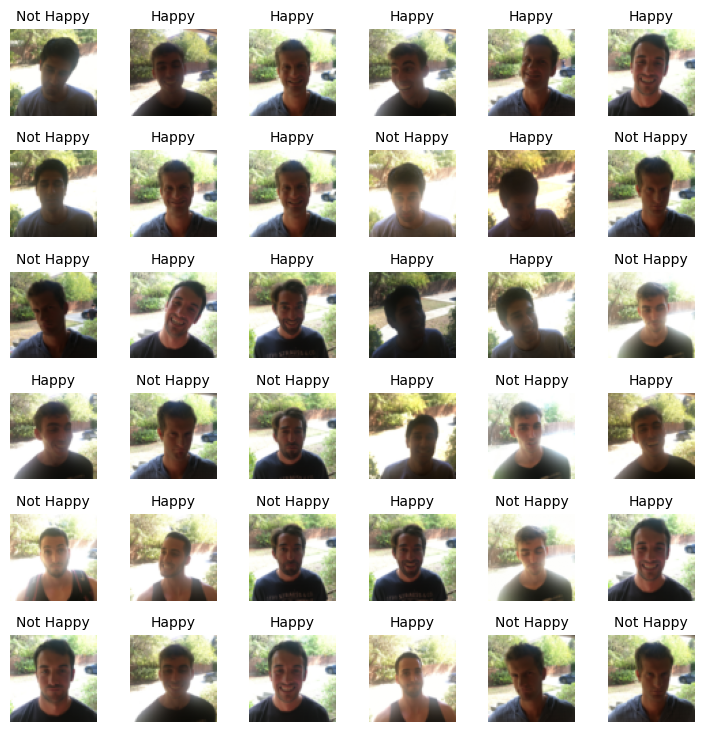

In [11]:
W_grid = 6
L_grid = 6

fig, axes = plt.subplots(L_grid, W_grid, figsize = (9,9))

axes = axes.ravel() # flaten the L_grid x W_grid matrix into L_grid * W_grid array

n_training = len(train_x) # get the length of the training dataset

for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    index = np.random.randint(0, n_training)
    axes[i].imshow(train_x[index])

    if train_y[index] == 1:
        axes[i].set_title("Happy", fontsize = 10)
    else:
        axes[i].set_title("Not Happy", fontsize = 10)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

### 3.2.4 Plot Utility Methods

The following code is used to plot accuracy and loss histories for each model experiment.

In [12]:
def plot(training_results, validation_results, results_type, model_name):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)


def plot_accuracy(history, model_name):
    plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', model_name)
    

def plot_loss(history, model_name):
    plot(history.history['loss'], history.history['val_loss'], 'Loss', model_name)

### 3.2.5 Custom CNN Model

**TODO**: Build a custom CNN model to solve the problem.

Model guidelines (You need to follow them):

1. [Input](https://keras.io/api/layers/core_layers/input/) Layer.
2. [ZeroPadding2D](https://keras.io/api/layers/reshaping_layers/zero_padding2d/) Layer.
3. [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) Layer.
4. [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) Layer. You can read [this article](https://kharshit.github.io/blog/2018/12/28/why-batch-normalization) to learn more about BatchNormalization.
5. Relu [Activation](https://keras.io/api/layers/core_layers/activation/).
6. [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) Layer.
7. [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) Layer.
8. [Dense](https://keras.io/api/layers/core_layers/dense/) with Sigmoid Layer (one perceptrion).

**Note**: If you made the required model, you can make other custom CNN models **if you wish** to further improve the accuracy, but in other code cells however.

In [13]:
def CustomCNN(input_shape):
    """
    Implementation of the Custom CNN.
    Args:
        input_shape () shape of the images of the dataset
    Returns:
        model (Keras.Model): CNN Custom Model
        model_name (Str): The name of the model
    """
    
    ### START CODE HERE ###
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    # Choose a suitable number of filters and kernel size
    X = Conv2D(filters=32, kernel_size=(7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Dense(32, activation='relu', name='relu0')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED (Dense)
    X = Flatten()(X)
    Y = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your tensorflow.keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=Y)
    ### END CODE HERE ###
    
    return model, "Custom CNN"

### 3.2.6 CNN Use Case No.1: VGG

![VGG Architecture](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab3/vgg.png?raw=1)

**Note**: this ia a show case to help you do the same with other use cases.

**TODO**: Try different variations for VGG:

1. [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)
2. [VGG19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19)

**Note**: *You will need to experiment all of them both pretrained (both with or without layers freezing) and also untrained, in the test section.*

In [14]:
def VGG(pretrained = True, input_shape = (64, 64, 3), model_name = "VGG16"):
    """
    Returns VGG Keras Model
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name
    Examples:
        VGG(True) -> Model, "Pretrained VGG16"
    """
    if(pretrained):
        base_model = getattr(tf.keras.applications, model_name)(
            weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
        model_name = "Pretrained " + model_name
    else:
        base_model = getattr(tf.keras.applications, model_name)(
            weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
        model_name = "Untrained " + model_name

    return base_model, model_name

### 3.2.7 CNN Use Case No.2: Residual Connections-based Networks

![VGG vs ResNet](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab3/VGG_vs_ResNet.png?raw=1)

**TODO**: Follow the same style for the above mentioned VGG and experiment the following Networks:

1. [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)
2. [ResNet101](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet101)
3. [InceptionResNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2/InceptionResNetV2) this network builds on the inception network architecture and incorporates [residual connections](https://towardsdatascience.com/what-is-residual-connection-efb07cab0d55), you can read more about it [here](https://paperswithcode.com/method/inception-resnet-v2#:~:text=Inception%2DResNet%2Dv2%20is%20a,stage%20of%20the%20Inception%20architecture).

**Note 1**: *You will need to experiment all of them both pretrained (both with or without layers freezing) and also untrained, in the test section.*

**Note 2**: For very deep networks like **InceptionResNetV2**, the size of the input might get reduced too much and an error might be produced, **you need to fix this issue by either [resizing input image](https://www.geeksforgeeks.org/image-resizing-using-opencv-python/) (preferred) or by adding padding (not preferred)**.

To resize the image you *can* follow the following steps (*just some possible guidelines)*:


*   Make a function similar to preprocess_data() but instead resize the train and test images before outputting them, using cv2.resize with interpolation
*   When you train the model that is causing the error, call this function to obtain the training and testing data instead of calling the original preprocess_data() (as was done at the beggining of the notebook) 



In [15]:
# The ResNet function refers to the above residual connection-based networks including the InceptionResNetV2 network
def ResNet(pretrained = True, input_shape = (64, 64, 3), model_name = "ResNet50"):
    """
    Returns ResNet Keras Model
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name
    Examples:
        ResNet(True) -> Model, "Pretrained ResNet50"
    """
    if(pretrained):
        # check model_name argument and load the corresponding model
        base_model = getattr(tf.keras.applications, model_name)(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')            
        model_name = "Pretrained " + model_name

    else:
        base_model = getattr(tf.keras.applications, model_name)(weights=None, include_top=False, input_shape=input_shape, pooling='none')
        model_name = "Untrained " + model_name
    return base_model, model_name

### 3.2.8 CNN Use Case No.3: Your choice

**TODO**: Select one application other than VGG or ResNet from [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications) and implement it the same way you did with VGG & ResNet.

**Note**: *You will need to experiment it in both pretrained (both with or without layers freezing) and also untrained, in the test section.*

In [16]:
def CNN_App(pretrained = True, input_shape = (64, 64, 3), model_name = "Xception"):
    """
    Returns A Custom CNN Application Keras Model
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name
    Examples:
        CNN_App(True, (64, 64, 3), "Xception") -> Model, "Pretrained Xception"
    """
    if(pretrained):
        model_name = "Pretrained " + model_name
        base_model = getattr(tf.keras.applications, model_name)(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
    else:
        model_name = "Untrained " + model_name
        base_model = getattr(tf.keras.applications, model_name)(weights=None, include_top=False, input_shape=input_shape, pooling='none')

    return base_model, model_name

In [17]:
def CNN_MAKER(pretrained=True, input_shape=(64, 64, 3), model_name="Xception"):
    """
    Returns A Custom CNN Application Keras Model
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name
    Examples:
        CNN_App(True, (64, 64, 3), "Xception") -> Model, "Pretrained Xception"
    """
    if (pretrained):
        base_model = getattr(tf.keras.applications, model_name)(
            weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
        model_name = "Pretrained " + model_name
    else:
        base_model = getattr(tf.keras.applications, model_name)(
            weights=None, include_top=False, input_shape=input_shape, pooling='none')
        model_name = "Untrained " + model_name

    return base_model, model_name


### 3.2.9 Layers Freezing

The following utility method is used for layers freezing.

**TODO**: *Experiment all the pretrained models with layers freezing using* **different number of frozen layers**.

**NOTE**: You will not change this method at all, the experimenting will take place in the test cases section below.

In [18]:
def freeze(model, number_of_frozen_layers):
    layers = model.layers

    layers = layers[:number_of_frozen_layers]

    for layer in layers:
        layer.trainable = False

    return model

### 3.2.10 Make your models

You can use the following utility method to make the model you desire, **modify it if you please**.

In [19]:
def make_model(pretrained=True, freeze_layers=False, number_of_frozen_layers=0, model_selection="VGG"):
    """
    Use this method to create models
    Args:
      pretrained (Bool): Whether make the model pretrained or not, doesn't apply to custom CNN.
      freeze_layers (Bool): Whether apply layers freezing on pretrained networks or not.
      number_of_frozen_layers (int): Number of frozen layers.
      model_selection (Str): Must be exactly "Custom", or "VGG", or "ResNet" or anything else for CNN_App
    """
    # ==================================================================== TAKE CARE ==========================================================================
    # You might need to make the input shape an additional parameter to the function instead of being statically defined here
    # This will help you configure the input_shape when you handle the error due to the vanishing input dimensions in very deep networks like inception_resnetV2
    input_shape = (64, 64, 3)


    if model_selection == "Custom":
        model, model_name = CustomCNN(input_shape)
    else:
        model, model_name = CNN_MAKER(pretrained, input_shape, model_name=model_selection)

    if model_selection != "Custom":
        if freeze_layers:
            model = freeze(model, number_of_frozen_layers)
            model_name = model_name + " with " + str(number_of_frozen_layers) + " Frozen Layers"

        ## Add classification head for non custom models
        y = model.output
        y = Flatten()(y)
        y = Dense(256, activation='relu')(y)
        y = Dense(1, activation='sigmoid', name='fc')(y)

        model = Model(inputs=model.input, outputs=y)

    return model, model_name

### 3.2.11 Testing model utility method

This is a generic method that will be used to test all the implemented models, a modular design allows you to experiment more clearly. **Modify it if you please.**

**TODO**:

1. Try different [optimizers](https://keras.io/api/optimizers/) and report their affect on the **results** and plots.
2. For each optimizer, try different learning rates and other hyperparameters (If applicable), and report the difference on the **results** and plots.
3. Try different [loss functions](https://keras.io/api/losses/), and report their affect on **accuracy** and plots. 

**Note**: You don't need to try different optimizers, rates and hyperparameters & losses on all models, **just find the best model with the current optimizers, rates and hyperparameters & losses** **then try your experiments** (changing optimizers, rates and hyperparameters & losses) only on this model.

***The best model is obtained after testing the different models defined above in different cases (untrained, pretrained without freezing, and pretrained with different number of frozen layers)***

In [30]:

def test_model(model, model_name, epochs=10, print_summary=True, plot_results=True):



    sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    # use GPU
    with tf.device('/device:GPU:0'):
        model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

        if (print_summary):
            model.summary()

        hist = model.fit(train_x, train_y, validation_data = (test_x, test_y), verbose=1, epochs=epochs, batch_size=32)
        preds = model.evaluate(test_x, test_y, batch_size=32, verbose=1, sample_weight=None)

        print ("Validation Loss = " + str(preds[0]))
        print ("Validation Accuracy = " + str(preds[1]))

        if(plot_results):
            plot_loss(hist, model_name)
            plot_accuracy(hist, model_name)

### 3.2.12 Create your model test cases.

**TODO**: Fill here all the test cases methods that you want to apply.

Add methods (Untrained, pretrained & pretrained with freezing) for *(at least)*:
1. ResNet
2. InceptionResnet
3. CNN App

**NOTE**: *Those test cases, don't change use case types (i.e. you will need to change the VGG in VGG() method to VGG19 and re test again or make another function for VGG19 for example) and doesn't change the loss function nor the optimizer type (these need to be changed in the testing utility method).*


In [21]:
def test_custom_CNN(epochs=20, print_summary=True, plot_results=True):
    model, model_name = make_model(False, False, 0, "Custom")
    test_model(model, model_name, epochs, print_summary, plot_results)

In [22]:
def test_untrained_VGG(epochs=20, print_summary=True, plot_results=True):
    model, model_name = make_model(False, False, 0, "VGG")
    test_model(model, model_name, epochs, print_summary, plot_results)

In [23]:
def test_pretrained_VGG(epochs=20, print_summary=True, plot_results=True):
    model, model_name = make_model(True, False, 0, "VGG")
    test_model(model, model_name, epochs, print_summary, plot_results)

In [24]:
def test_pretrained_layers_freezing_VGG(epochs=20, print_summary=True, plot_results=True):
    model, model_name = make_model(True, True, 5, "VGG")
    test_model(model, model_name, epochs, print_summary, plot_results)

In [25]:
def test_untrained_ResNet(epochs=20, print_summary=True, plot_results=True):
    model, model_name = make_model(False, False, 0, "ResNet")
    test_model(model, model_name, epochs, print_summary, plot_results)

In [26]:
def test_model_given_name(epochs=20, print_summary=True, plot_results=True, model_name="ResNet50", pretrained=False, freeze_layers=False, number_of_frozen_layers=0):
    model, model_name = make_model( pretrained, freeze_layers, number_of_frozen_layers, model_name)
    test_model(model, model_name, epochs, print_summary, plot_results)


###  3.2.13 Test your models

**TODO**: Call all your defined methods for testing here. 

**Note**: You might want to go up to **1000** epochs for the untrained model if the validation accuracy is low.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 70, 70, 3)        0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 64, 64, 32)        4736      
                                                                 
 bn0 (BatchNormalization)    (None, 64, 64, 32)        128       
                                                                 
 relu0 (Dense)               (None, 64, 64, 32)        1056      
                                                                 
 max_pool0 (MaxPooling2D)    (None, 32, 32, 32)        0         
                                                           

/home/kiro/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - 1s 28ms/step - loss: 0.6809 - accuracy: 0.5683 - val_loss: 0.6826 - val_accuracy: 0.5267
Epoch 2/20
19/19 [==============================] - 0s 23ms/step - loss: 0.4913 - accuracy: 0.7883 - val_loss: 0.6665 - val_accuracy: 0.5867
Epoch 3/20
19/19 [==============================] - 0s 23ms/step - loss: 0.3962 - accuracy: 0.8467 - val_loss: 0.6451 - val_accuracy: 0.6867
Epoch 4/20
19/19 [==============================] - 0s 22ms/step - loss: 0.3293 - accuracy: 0.8900 - val_loss: 0.6194 - val_accuracy: 0.8067
Epoch 5/20
19/19 [==============================] - 0s 22ms/step - loss: 0.2916 - accuracy: 0.9217 - val_loss: 0.6003 - val_accuracy: 0.8200
Epoch 6/20
19/19 [==============================] - 0s 22ms/step - loss: 0.2622 - accuracy: 0.9283 - val_loss: 0.5840 - val_accuracy: 0.7733
Epoch 7/20
19/19 [==============================] - 0s 22ms/step - loss: 0.2381 - accuracy: 0.9383 - val_loss: 0.5567 - val_accuracy: 0.8600
Epoch 8/20
19/19 [======

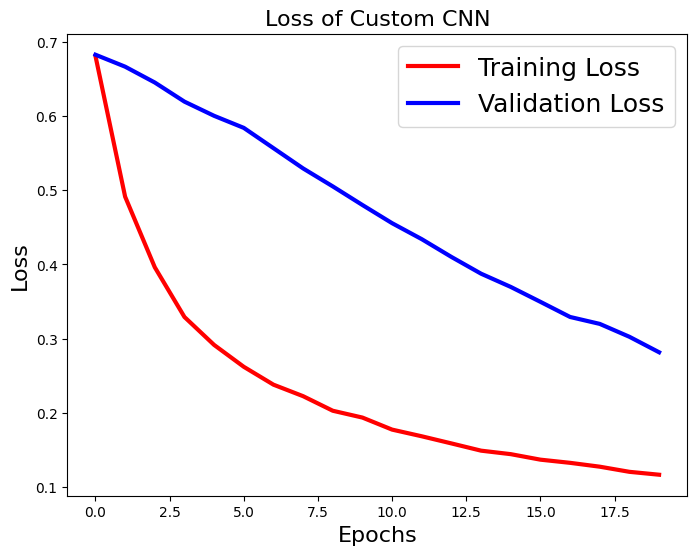

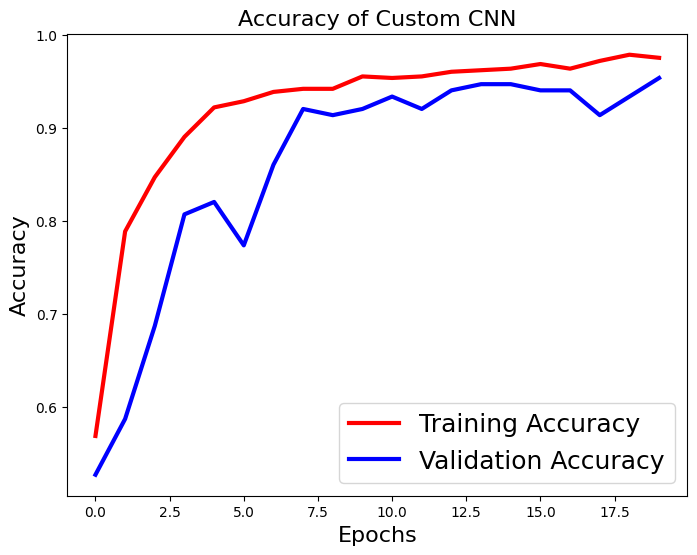

In [ ]:
test_model_given_name(epochs=20, print_summary=True, plot_results=True, model_name="Custom", pretrained=False, freeze_layers=False, number_of_frozen_layers=0)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 70, 70, 3)        0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 64, 64, 32)        4736      
                                                                 
 bn0 (BatchNormalization)    (None, 64, 64, 32)        128       
                                                                 
 relu0 (Dense)               (None, 64, 64, 32)        1056      
                                                                 
 max_pool0 (MaxPooling2D)    (None, 32, 32, 32)        0         
                                                             

2023-03-26 11:18:41.636780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 11:18:41.637187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiro/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-26 11:18:41.637231: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiro/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-26 11:18:41.637256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load d

19/19 [==============================] - 1s 31ms/step - loss: 0.6300 - accuracy: 0.6383 - val_loss: 0.6703 - val_accuracy: 0.6800
Epoch 2/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.4314 - accuracy: 0.8383 - val_loss: 0.6493 - val_accuracy: 0.7333
Epoch 3/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.3400 - accuracy: 0.8883 - val_loss: 0.6325 - val_accuracy: 0.7933
Epoch 4/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.2862 - accuracy: 0.9133 - val_loss: 0.6129 - val_accuracy: 0.8400
Epoch 5/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.2564 - accuracy: 0.9167 - val_loss: 0.5926 - val_accuracy: 0.8867
Epoch 6/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.2307 - accuracy: 0.9383 - val_loss: 0.5707 - val_accuracy: 0.8333
Epoch 7/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.2125 - accuracy: 0.9417 - val_loss: 0.5537 - val_accuracy: 0.9067
Epoch 8/1000

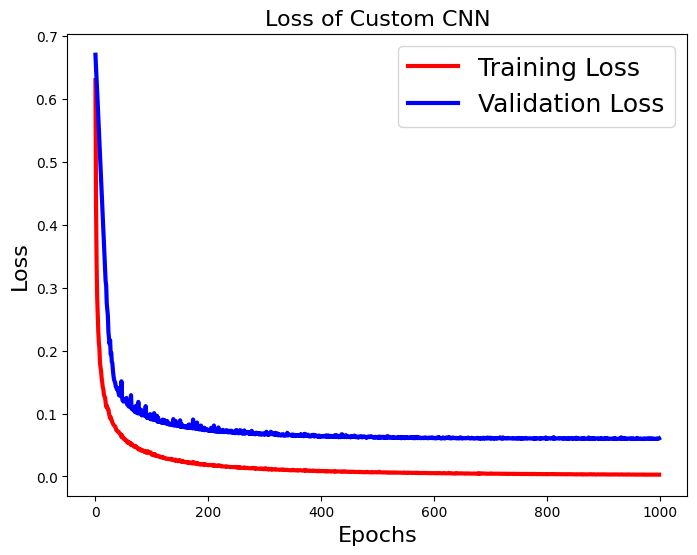

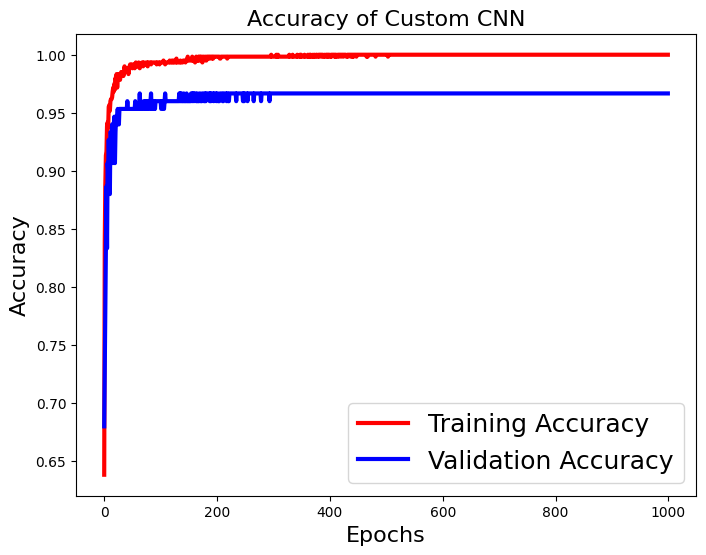

In [25]:
test_model_given_name(epochs=1000, print_summary=True, plot_results=True, model_name="Custom",
                      pretrained=False, freeze_layers=False, number_of_frozen_layers=0)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 70, 70, 3)        0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 64, 64, 32)        4736      
                                                                 
 bn0 (BatchNormalization)    (None, 64, 64, 32)        128       
                                                                 
 relu0 (Dense)               (None, 64, 64, 32)        1056      
                                                                 
 max_pool0 (MaxPooling2D)    (None, 32, 32, 32)        0         
                                                             

2023-03-26 17:31:19.586402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 17:31:19.586841: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiro/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-26 17:31:19.586891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiro/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-26 17:31:19.586918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load d

19/19 [==============================] - 1s 31ms/step - loss: 0.6271 - accuracy: 0.6083 - val_loss: 0.6919 - val_accuracy: 0.4600
Epoch 2/20
19/19 [==============================] - 0s 24ms/step - loss: 0.4332 - accuracy: 0.8117 - val_loss: 0.6638 - val_accuracy: 0.6133
Epoch 3/20
19/19 [==============================] - 0s 23ms/step - loss: 0.3371 - accuracy: 0.8950 - val_loss: 0.6350 - val_accuracy: 0.7000
Epoch 4/20
19/19 [==============================] - 0s 23ms/step - loss: 0.2853 - accuracy: 0.9300 - val_loss: 0.6126 - val_accuracy: 0.7267
Epoch 5/20
19/19 [==============================] - 0s 24ms/step - loss: 0.2416 - accuracy: 0.9383 - val_loss: 0.5869 - val_accuracy: 0.8200
Epoch 6/20
19/19 [==============================] - 0s 24ms/step - loss: 0.2212 - accuracy: 0.9450 - val_loss: 0.5668 - val_accuracy: 0.8467
Epoch 7/20
19/19 [==============================] - 0s 23ms/step - loss: 0.1985 - accuracy: 0.9500 - val_loss: 0.5442 - val_accuracy: 0.8733
Epoch 8/20
19/19 [======

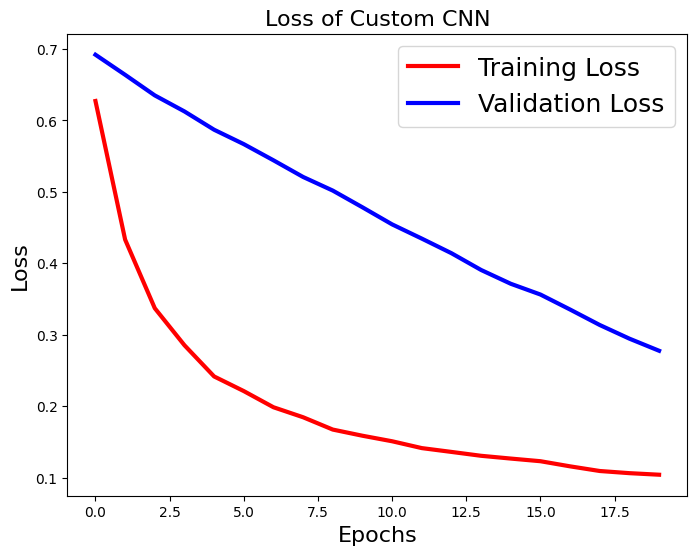

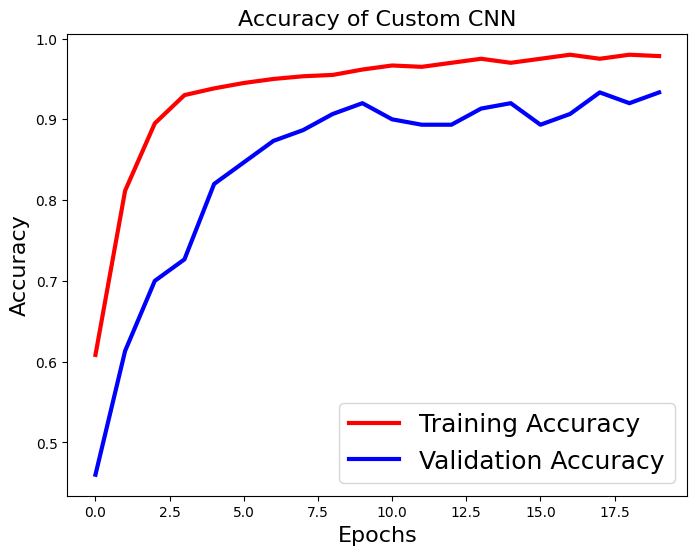

In [24]:
test_model_given_name(epochs=20, print_summary=True, plot_results=True, model_name="Custom",
                      pretrained=True, freeze_layers=False, number_of_frozen_layers=0)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 70, 70, 3)        0         
 ng2D)                                                           
                                                                 
 conv0 (Conv2D)              (None, 64, 64, 32)        4736      
                                                                 
 bn0 (BatchNormalization)    (None, 64, 64, 32)        128       
                                                                 
 relu0 (Dense)               (None, 64, 64, 32)        1056      
                                                                 
 max_pool0 (MaxPooling2D)    (None, 32, 32, 32)        0         
                                                           

/home/kiro/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - 1s 28ms/step - loss: 0.6493 - accuracy: 0.6117 - val_loss: 0.6884 - val_accuracy: 0.5200
Epoch 2/20
19/19 [==============================] - 0s 23ms/step - loss: 0.4514 - accuracy: 0.8217 - val_loss: 0.6505 - val_accuracy: 0.6067
Epoch 3/20
19/19 [==============================] - 0s 24ms/step - loss: 0.3555 - accuracy: 0.8883 - val_loss: 0.6359 - val_accuracy: 0.7067
Epoch 4/20
19/19 [==============================] - 0s 25ms/step - loss: 0.3105 - accuracy: 0.8983 - val_loss: 0.6108 - val_accuracy: 0.7533
Epoch 5/20
19/19 [==============================] - 0s 24ms/step - loss: 0.2692 - accuracy: 0.9233 - val_loss: 0.5893 - val_accuracy: 0.8267
Epoch 6/20
19/19 [==============================] - 0s 23ms/step - loss: 0.2439 - accuracy: 0.9350 - val_loss: 0.5706 - val_accuracy: 0.8067
Epoch 7/20
19/19 [==============================] - 0s 24ms/step - loss: 0.2266 - accuracy: 0.9400 - val_loss: 0.5464 - val_accuracy: 0.8733
Epoch 8/20
19/19 [======

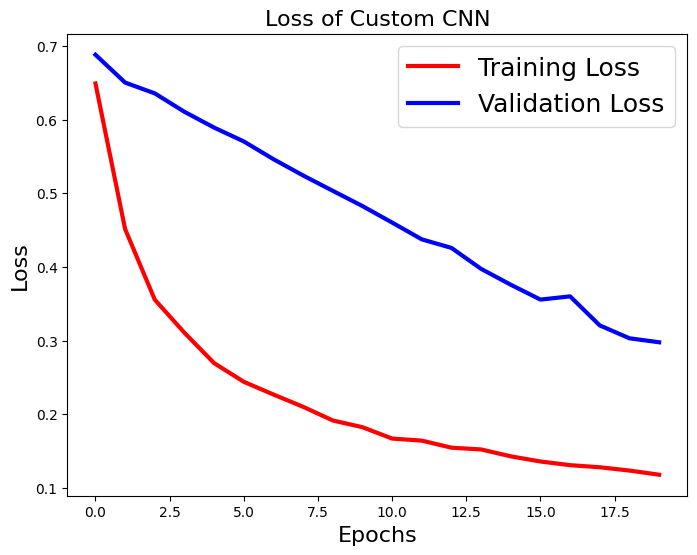

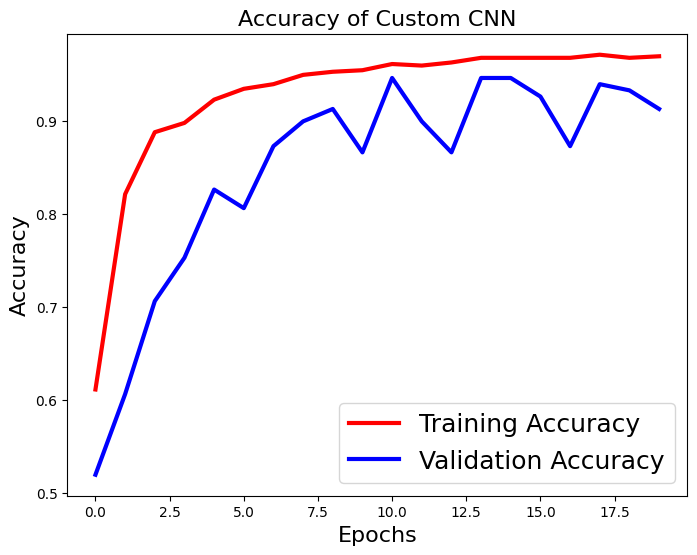

In [25]:
test_model_given_name(epochs=20, print_summary=True, plot_results=True, model_name="Custom",
                      pretrained=True, freeze_layers=True, number_of_frozen_layers=5)


# ResNet50 Untrained

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

/home/kiro/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - 7s 225ms/step - loss: 0.8962 - accuracy: 0.4983 - val_loss: 0.6918 - val_accuracy: 0.5600
Epoch 2/20
19/19 [==============================] - 4s 196ms/step - loss: 0.8256 - accuracy: 0.5350 - val_loss: 0.6895 - val_accuracy: 0.5600
Epoch 3/20
19/19 [==============================] - 4s 195ms/step - loss: 0.7286 - accuracy: 0.6000 - val_loss: 0.7041 - val_accuracy: 0.3933
Epoch 4/20
19/19 [==============================] - 4s 194ms/step - loss: 0.6173 - accuracy: 0.6683 - val_loss: 0.7106 - val_accuracy: 0.4400
Epoch 5/20
19/19 [==============================] - 4s 193ms/step - loss: 0.5211 - accuracy: 0.7483 - val_loss: 0.7355 - val_accuracy: 0.4400
Epoch 6/20
19/19 [==============================] - 4s 194ms/step - loss: 0.4455 - accuracy: 0.8017 - val_loss: 0.7363 - val_accuracy: 0.4400
Epoch 7/20
19/19 [==============================] - 4s 193ms/step - loss: 0.3544 - accuracy: 0.8400 - val_loss: 0.7233 - val_accuracy: 0.4467
Epoch 8/20
19/19 

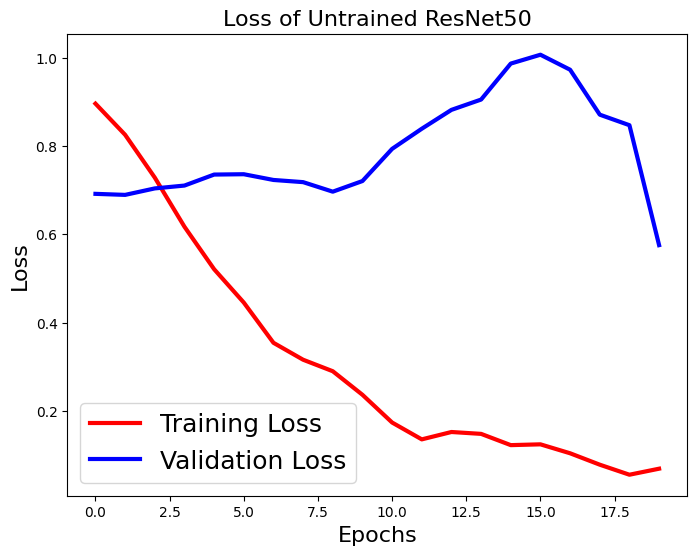

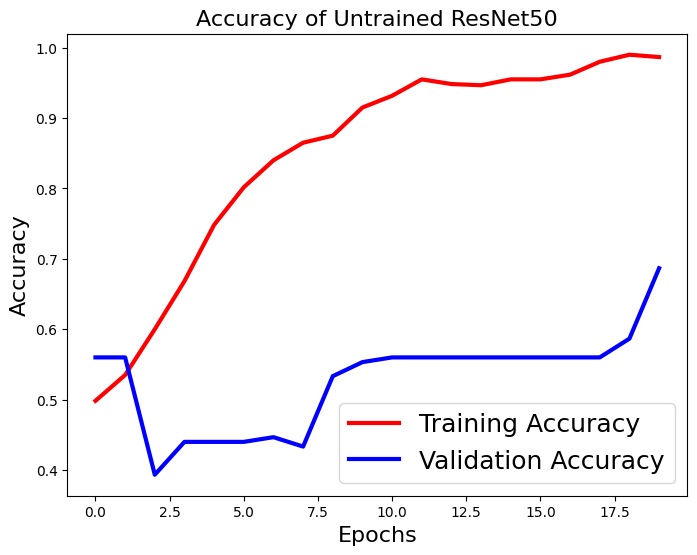

In [30]:
test_model_given_name(epochs=20, print_summary=True, plot_results=True, model_name="ResNet50")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

/home/kiro/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/1000
19/19 [==============================] - 7s 228ms/step - loss: 0.9825 - accuracy: 0.5200 - val_loss: 0.6879 - val_accuracy: 0.5733
Epoch 2/1000
19/19 [==============================] - 4s 202ms/step - loss: 0.8053 - accuracy: 0.5617 - val_loss: 0.6841 - val_accuracy: 0.5533
Epoch 3/1000
19/19 [==============================] - 4s 202ms/step - loss: 0.7591 - accuracy: 0.5617 - val_loss: 0.6857 - val_accuracy: 0.5600
Epoch 4/1000
19/19 [==============================] - 4s 202ms/step - loss: 0.6508 - accuracy: 0.6550 - val_loss: 0.6833 - val_accuracy: 0.5600
Epoch 5/1000
19/19 [==============================] - 4s 202ms/step - loss: 0.6339 - accuracy: 0.6817 - val_loss: 0.6854 - val_accuracy: 0.5600
Epoch 6/1000
19/19 [==============================] - 4s 206ms/step - loss: 0.4804 - accuracy: 0.7583 - val_loss: 0.6786 - val_accuracy: 0.5600
Epoch 7/1000
19/19 [==============================] - 4s 202ms/step - loss: 0.4050 - accuracy: 0.8100 - val_loss: 0.6942 - val_accuracy:

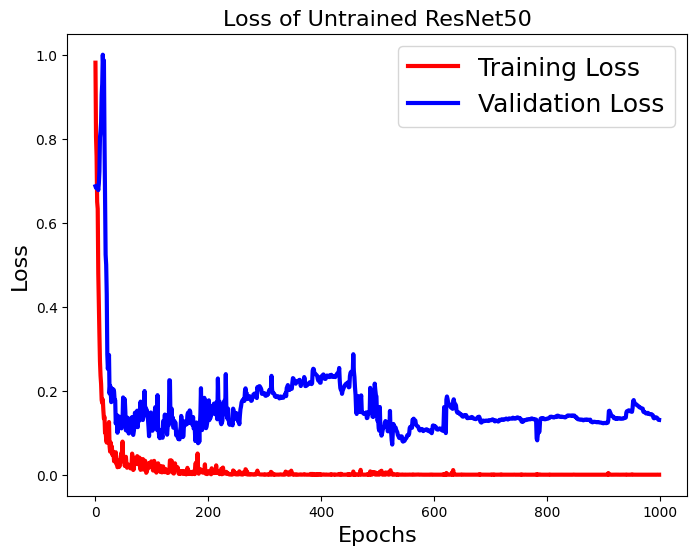

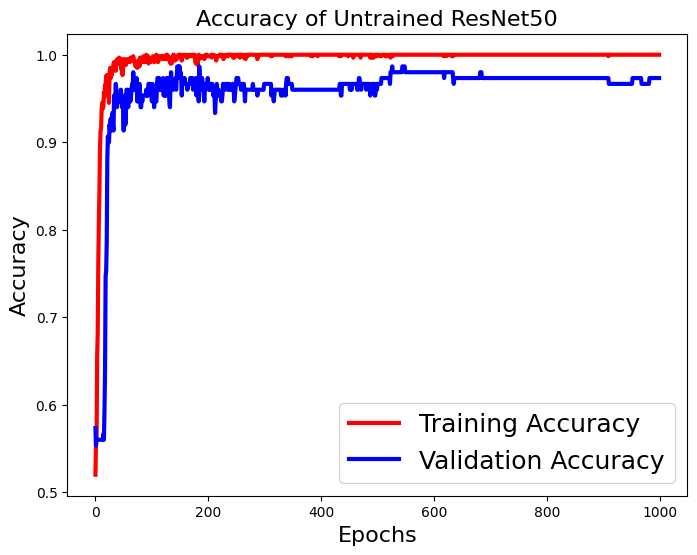

In [26]:
test_model_given_name(epochs=1000, print_summary=True,
                      plot_results=True, model_name="ResNet50")


## ResNet50 Pretrained

94765736/94765736 [==============================] - 27s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                          

/home/kiro/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - 7s 220ms/step - loss: 0.6652 - accuracy: 0.6817 - val_loss: 0.7281 - val_accuracy: 0.4400
Epoch 2/20
19/19 [==============================] - 4s 194ms/step - loss: 0.2115 - accuracy: 0.9417 - val_loss: 0.7299 - val_accuracy: 0.4333
Epoch 3/20
19/19 [==============================] - 4s 194ms/step - loss: 0.1091 - accuracy: 0.9817 - val_loss: 1.1477 - val_accuracy: 0.4400
Epoch 4/20
19/19 [==============================] - 4s 193ms/step - loss: 0.0758 - accuracy: 0.9917 - val_loss: 2.9526 - val_accuracy: 0.4400
Epoch 5/20
19/19 [==============================] - 4s 195ms/step - loss: 0.0583 - accuracy: 0.9967 - val_loss: 2.9132 - val_accuracy: 0.4400
Epoch 6/20
19/19 [==============================] - 4s 195ms/step - loss: 0.0399 - accuracy: 0.9983 - val_loss: 1.9631 - val_accuracy: 0.4400
Epoch 7/20
19/19 [==============================] - 4s 194ms/step - loss: 0.0389 - accuracy: 0.9967 - val_loss: 6.7413 - val_accuracy: 0.5600
Epoch 8/20
19/19 

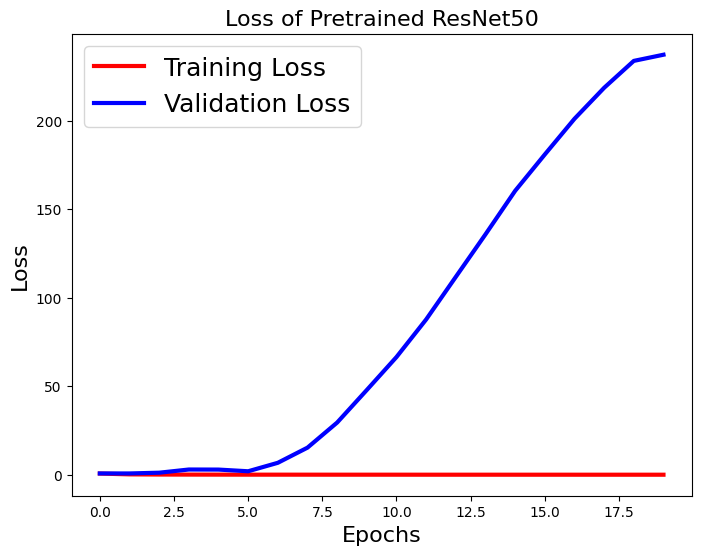

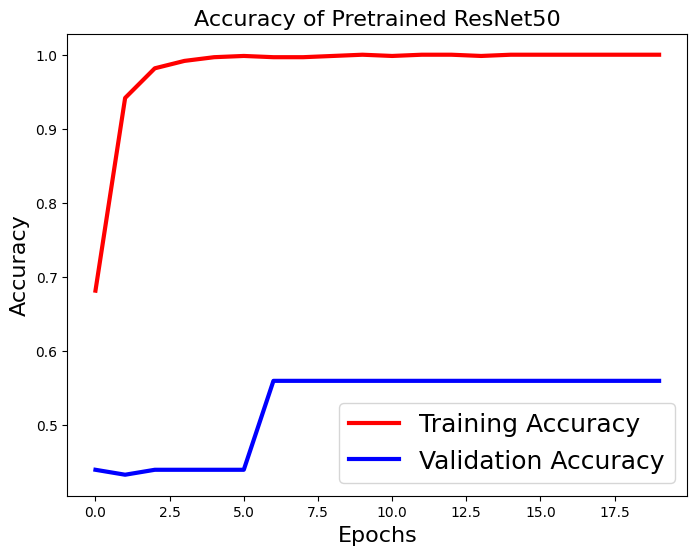

In [34]:
test_model_given_name(epochs=20, print_summary=True, plot_results=True, model_name="ResNet50", pretrained=True)

## ResNet50 Pretrained with freezing

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

/home/kiro/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - 6s 216ms/step - loss: 0.6793 - accuracy: 0.6500 - val_loss: 0.8957 - val_accuracy: 0.4400
Epoch 2/20
19/19 [==============================] - 4s 188ms/step - loss: 0.2068 - accuracy: 0.9500 - val_loss: 1.3888 - val_accuracy: 0.4400
Epoch 3/20
19/19 [==============================] - 4s 189ms/step - loss: 0.1074 - accuracy: 0.9800 - val_loss: 2.4706 - val_accuracy: 0.4400
Epoch 4/20
19/19 [==============================] - 4s 188ms/step - loss: 0.0800 - accuracy: 0.9900 - val_loss: 2.1729 - val_accuracy: 0.4400
Epoch 5/20
19/19 [==============================] - 4s 188ms/step - loss: 0.0554 - accuracy: 0.9967 - val_loss: 0.7192 - val_accuracy: 0.5600
Epoch 6/20
19/19 [==============================] - 4s 187ms/step - loss: 0.0457 - accuracy: 0.9933 - val_loss: 1.7585 - val_accuracy: 0.5600
Epoch 7/20
19/19 [==============================] - 4s 189ms/step - loss: 0.0369 - accuracy: 0.9967 - val_loss: 4.3248 - val_accuracy: 0.5600
Epoch 8/20
19/19 

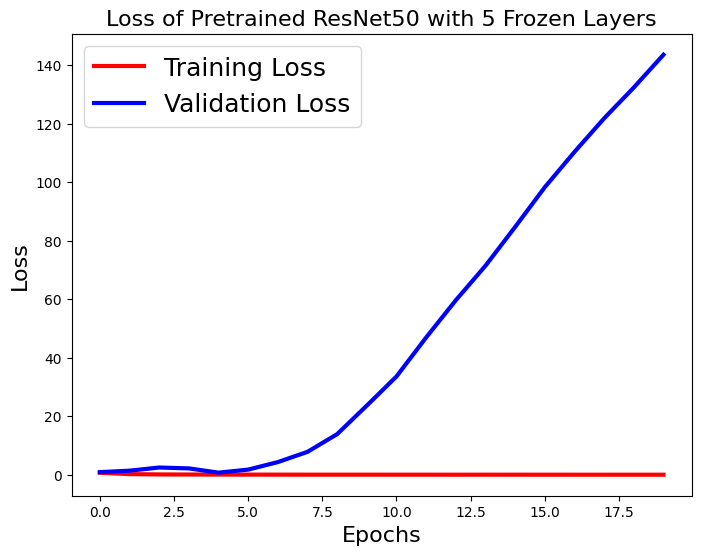

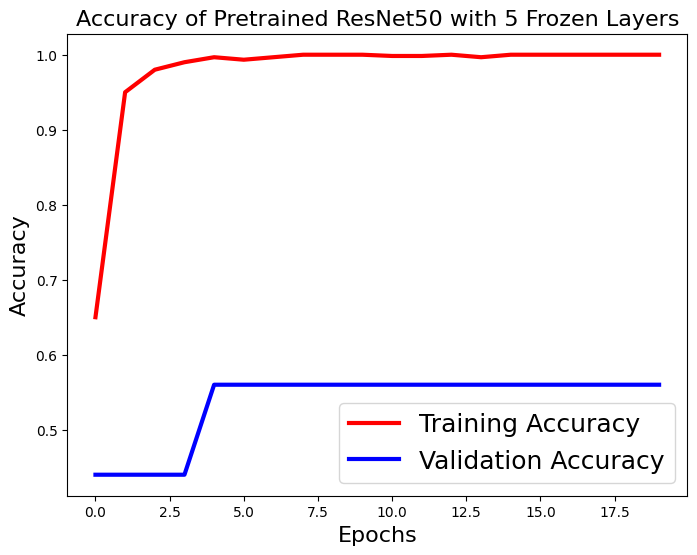

In [35]:
test_model_given_name(epochs=20, print_summary=True, plot_results=True, model_name="ResNet50", pretrained=True, freeze_layers=True, number_of_frozen_layers=5)

## Resnet101

2023-03-26 22:46:12.174015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-26 22:46:12.174554: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

/home/kiro/.local/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv4_block18_3_bn (BatchNorma  (None, 4, 4, 1024)  4096        ['conv4_block18_3_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block18_add (Add)        (None, 4, 4, 1024)   0           ['conv4_block17_out[0][0]',      
                                                                  'conv4_block18_3_bn[0][0]']     
                                                                                                  
 conv4_block18_out (Activation)  (None, 4, 4, 1024)  0           ['conv4_block18_add[0][0]']      
                                                                                                  
 conv4_block19_1_conv (Conv2D)  (None, 4, 4, 256)    262400      ['conv4_block18_out[0][0]']      
                                                                                                  
 conv4_blo

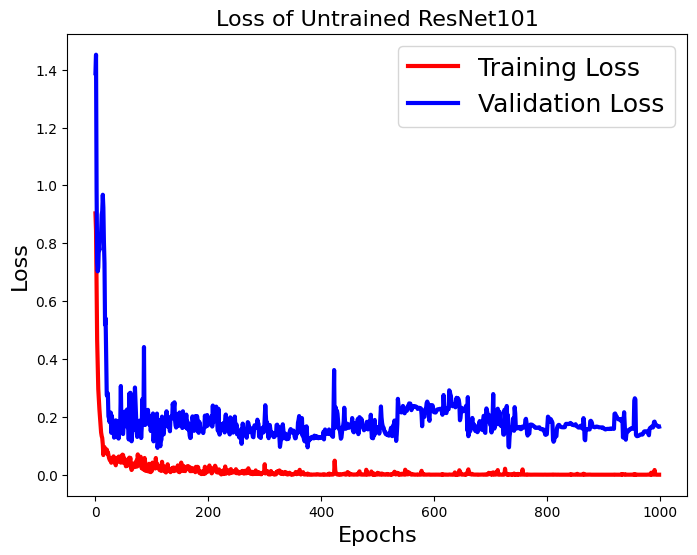

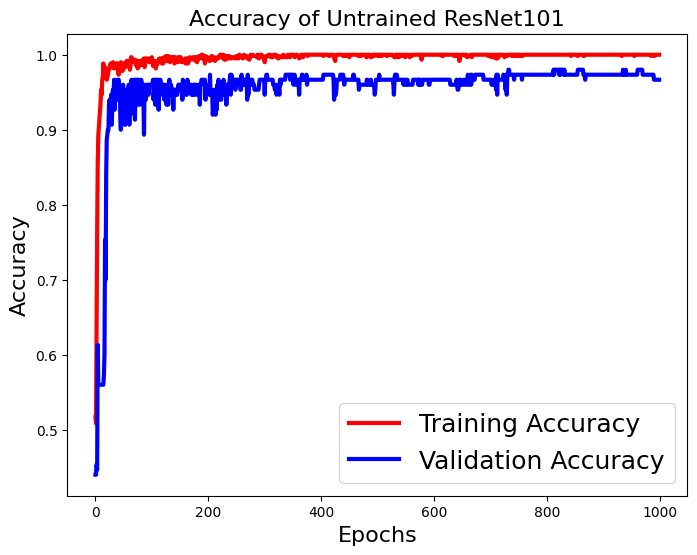

In [25]:
test_model_given_name(epochs=1000, print_summary=True, plot_results=True, model_name="ResNet101", pretrained=False, freeze_layers=False, number_of_frozen_layers=0)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

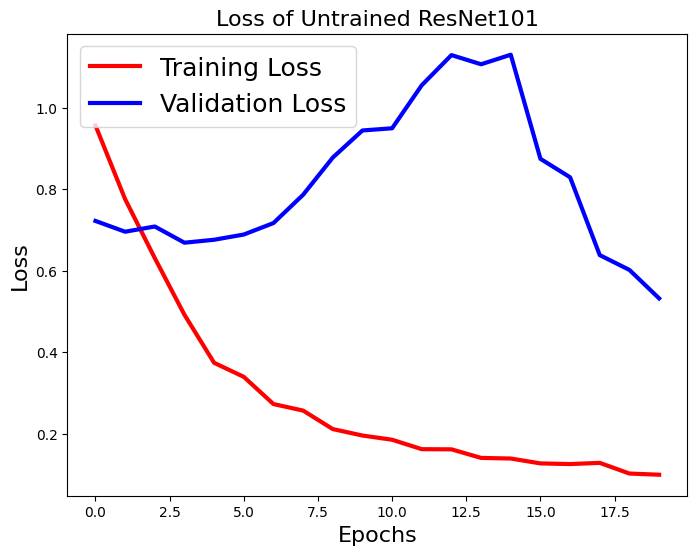

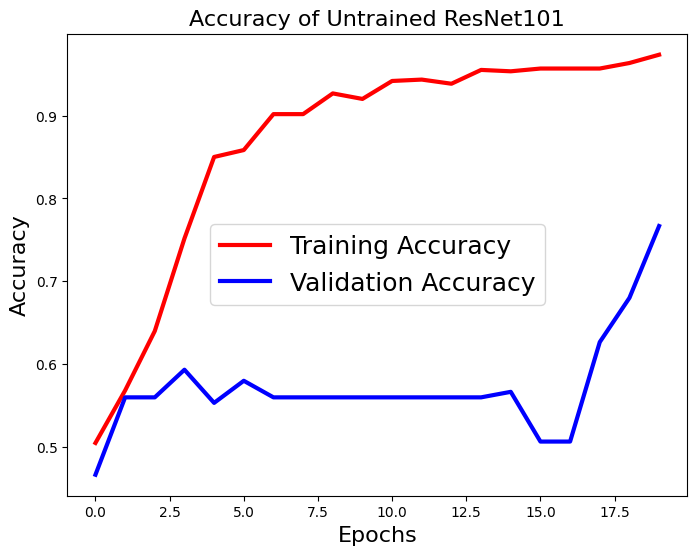

In [31]:
test_model_given_name(epochs=20, print_summary=True, plot_results=True, model_name="ResNet101")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

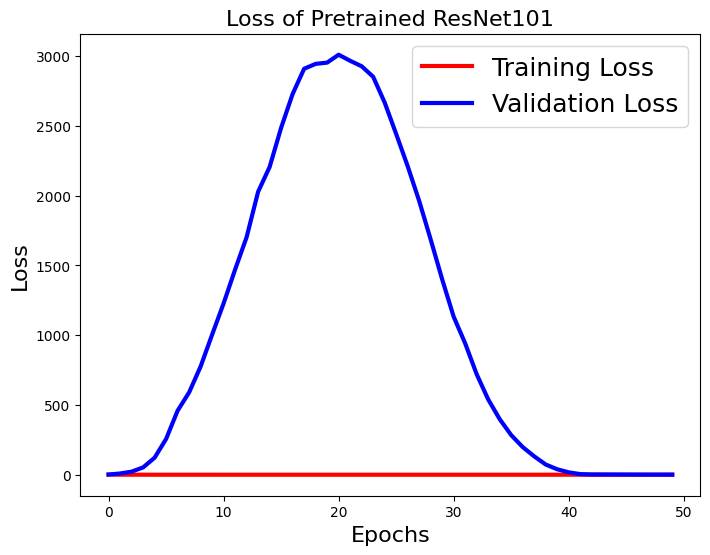

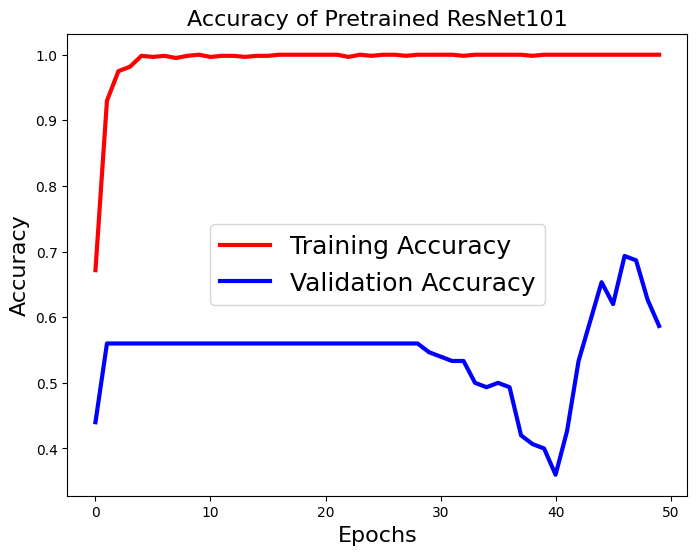

In [28]:
test_model_given_name(epochs=50, print_summary=True, plot_results=True,
                      model_name="ResNet101", pretrained=True
                      , freeze_layers=False, number_of_frozen_layers=0)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

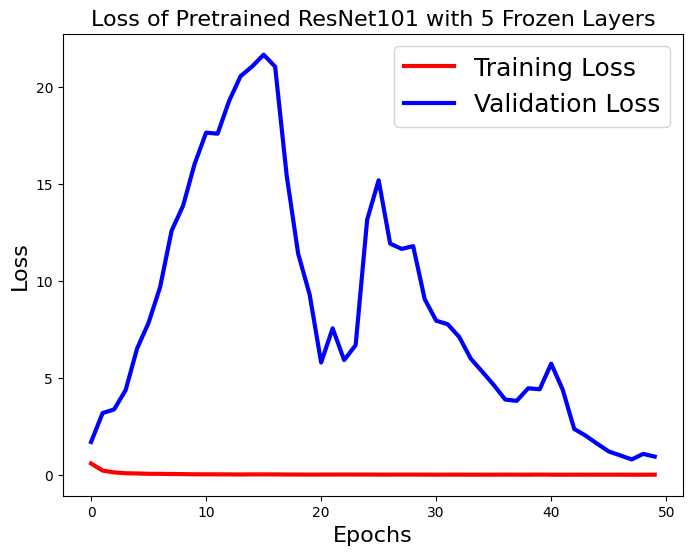

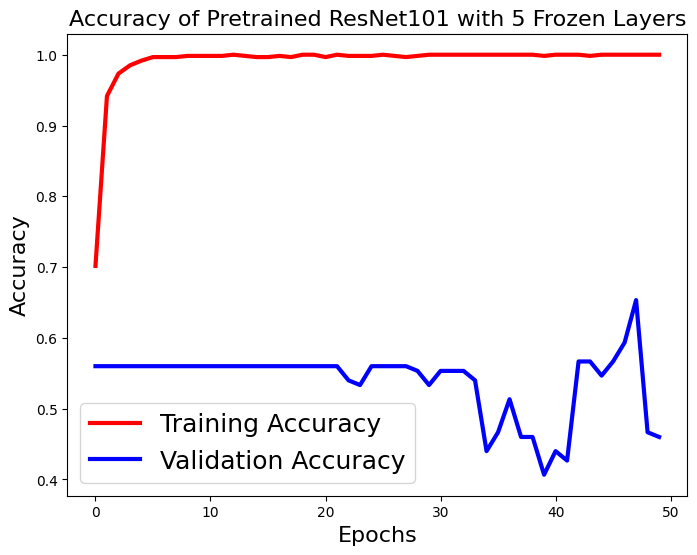

In [29]:
test_model_given_name(epochs=50, print_summary=True, plot_results=True,
                      model_name="ResNet101", pretrained=True, freeze_layers=True, number_of_frozen_layers=5)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

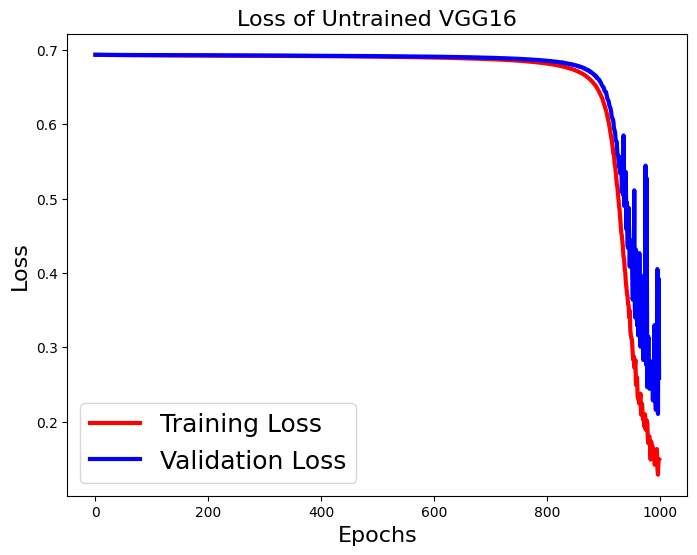

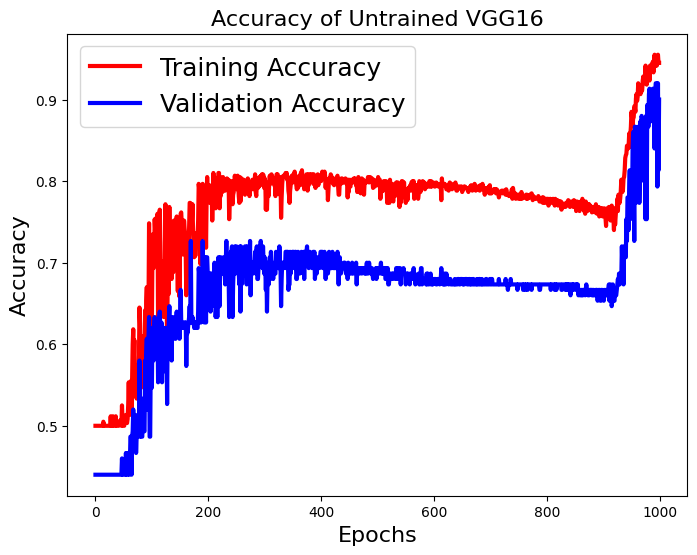

In [31]:
test_model_given_name(epochs=1000, print_summary=True, plot_results=True,
                      model_name="VGG16", pretrained=False, freeze_layers=False, number_of_frozen_layers=0)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

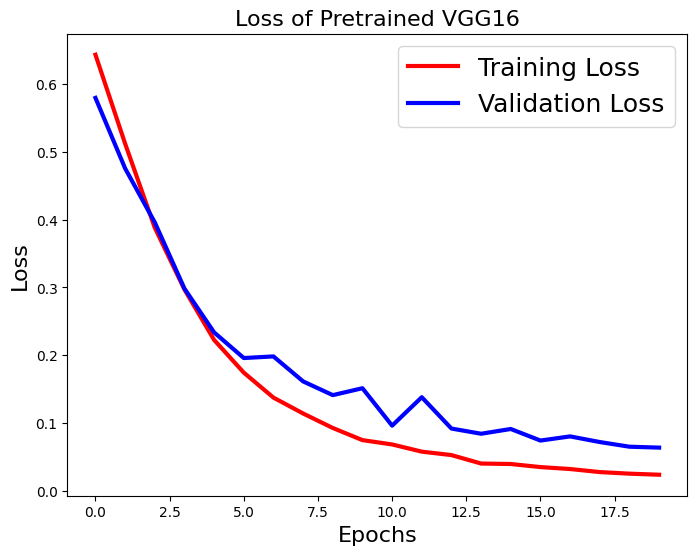

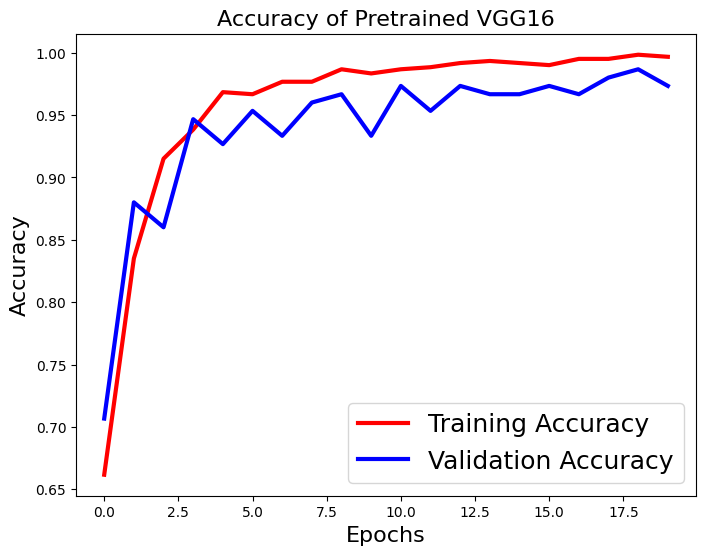

In [32]:
test_model_given_name(epochs=20, print_summary=True, plot_results=True,
                      model_name="VGG16", pretrained=True, freeze_layers=False, number_of_frozen_layers=0)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

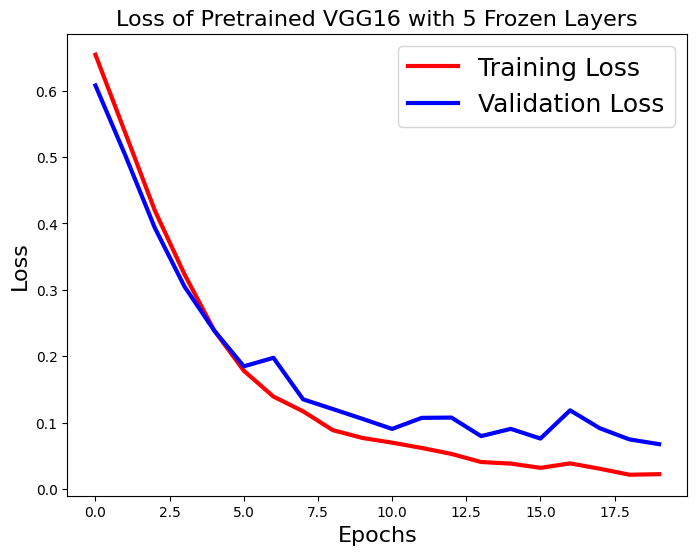

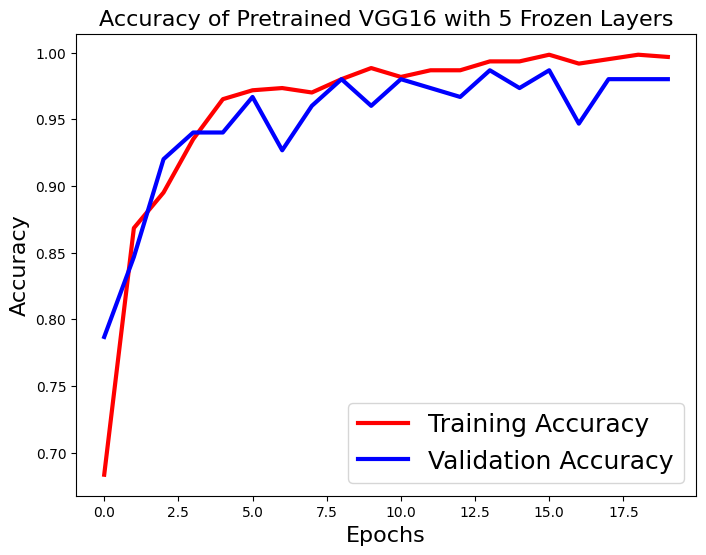

In [33]:
test_model_given_name(epochs=20, print_summary=True, plot_results=True,
                      model_name="VGG16", pretrained=True, freeze_layers=True, number_of_frozen_layers=5)


In [34]:
test_model_given_name(epochs=1000, print_summary=True, plot_results=True,
                      model_name="VGG19", pretrained=False, freeze_layers=False, number_of_frozen_layers=0)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

KeyboardInterrupt: 

## 3.3 Conclusion

That's it! Congratulations on training CNN use cases models.

Make sure you deliver all the requirements for the submission.